In [5]:
import pandas as pd
import os

# --- Configuration ---
file_name = "250331 Leng Survey. Full download. Editable.xlsx"
file_path = file_name # Or provide the full path

# --- Reading all sheets ---
try:
    all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
    print("Successfully read all sheets.")
    print(f"Sheet names found: {list(all_sheets_dict.keys())}")

    # --- Accessing the DataFrames ---
    # You now have DataFrames for each sheet in the dictionary:

    df_all_responses = all_sheets_dict['All responses']
    df_pa_survey = all_sheets_dict['PA Survey']
    df_aa_survey = all_sheets_dict['AA Survey']

    # --- Example: Print shapes or heads ---
    print("\n--- DataFrame Details ---")
    print(f"Shape of 'All responses': {df_all_responses.shape}")
    # print("Head of 'All responses':\n", df_all_responses.head()) # Uncomment to view

    print(f"\nShape of 'PA Survey': {df_pa_survey.shape}")
    # print("Head of 'PA Survey':\n", df_pa_survey.head()) # Uncomment to view

    print(f"\nShape of 'AA Survey': {df_aa_survey.shape}")
    # print("Head of 'AA Survey':\n", df_aa_survey.head()) # Uncomment to view

    # Or iterate through them:
    print("\n--- Iterating ---")
    for sheet_name, df in all_sheets_dict.items():
        print(f"Processing sheet: '{sheet_name}' with shape {df.shape}")
        # Add your analysis for each df here

except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read all sheets.
Sheet names found: ['All responses', 'PA Survey', 'AA Survey']

--- DataFrame Details ---
Shape of 'All responses': (8558, 138)

Shape of 'PA Survey': (6864, 137)

Shape of 'AA Survey': (1694, 137)

--- Iterating ---
Processing sheet: 'All responses' with shape (8558, 138)
Processing sheet: 'PA Survey' with shape (6864, 137)
Processing sheet: 'AA Survey' with shape (1694, 137)


In [6]:
import pandas as pd
import numpy as np

# --- ASSUMPTION ---
# This code assumes the 'all_sheets_dict' dictionary containing your DataFrames
# already exists in your environment from the previous steps.
# It specifically expects the 'All responses' sheet to be present.
# If not, you would first need to run the code that does:
# file_path = "250331 Leng Survey. Full download. Editable.xlsx"
# all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
# --- END ASSUMPTION ---

sheet_name = 'All responses'
print(f"--- Analyzing columns of sheet: '{sheet_name}' ---")

try:
    # --- Get the target DataFrame ---
    if 'all_sheets_dict' not in locals():
        raise NameError("The dictionary 'all_sheets_dict' does not exist. Please run the reading code first.")
    if sheet_name not in all_sheets_dict:
        raise KeyError(f"Sheet name '{sheet_name}' not found in the dictionary. Available sheets: {list(all_sheets_dict.keys())}")

    # Assign the specific DataFrame to the variable name you mentioned
    df_all_responses = all_sheets_dict[sheet_name]

    # --- Create Metadata DataFrame (describing columns of df_all_responses) ---
    print("Calculating unique values for each column in df_all_responses...")
    column_unique_counts = df_all_responses.nunique()

    # Create a DataFrame to hold metadata about the columns
    # The index of this DataFrame will be the column names from df_all_responses
    column_metadata_df = pd.DataFrame({
        'UniqueValues': column_unique_counts,
        'DataType': df_all_responses.dtypes # Added data type back for context
    })

    # --- Add the ResponseType classification to the metadata DataFrame ---
    print("Classifying columns based on unique value count...")
    column_metadata_df['ResponseType'] = np.where(
        column_metadata_df['UniqueValues'] <= 10, # Condition
        'Fixed Response',                         # Value if True
        'Open Text'                               # Value if False
    )

    # --- Display the Column Metadata ---
    print("\n--- Column Metadata DataFrame ---")
    print("(Describes the columns in 'df_all_responses')")
    with pd.option_context('display.max_rows', None):
        print(column_metadata_df)

    # --- How to USE this metadata with df_all_responses ---
    print("\n--- Example Usage ---")

    # 1. Get a list of column names classified as 'Open Text'
    open_text_column_names = column_metadata_df[column_metadata_df['ResponseType'] == 'Open Text'].index.tolist()
    print(f"\nNumber of 'Open Text' columns found: {len(open_text_column_names)}")
    if open_text_column_names:
        print(f"First few 'Open Text' columns: {open_text_column_names[:5]}...") # Show first 5

    # 2. Get a list of column names classified as 'Fixed Response'
    fixed_response_column_names = column_metadata_df[column_metadata_df['ResponseType'] == 'Fixed Response'].index.tolist()
    print(f"\nNumber of 'Fixed Response' columns found: {len(fixed_response_column_names)}")
    if fixed_response_column_names:
        print(f"First few 'Fixed Response' columns: {fixed_response_column_names[:5]}...") # Show first 5

    # 3. Create a new DataFrame containing only the 'Open Text' columns from the original data
    if open_text_column_names:
        df_open_text_only = df_all_responses[open_text_column_names]
        print("\nCreated 'df_open_text_only' DataFrame with shape:", df_open_text_only.shape)
        # print(df_open_text_only.head()) # Uncomment to see the head

    # 4. Create a new DataFrame containing only the 'Fixed Response' columns
    if fixed_response_column_names:
        df_fixed_response_only = df_all_responses[fixed_response_column_names]
        print("Created 'df_fixed_response_only' DataFrame with shape:", df_fixed_response_only.shape)
        # print(df_fixed_response_only.head()) # Uncomment to see the head


except (NameError, KeyError) as e:
     print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(f"\n--- Column analysis and classification complete for '{sheet_name}' ---")

--- Analyzing columns of sheet: 'All responses' ---
Calculating unique values for each column in df_all_responses...
Classifying columns based on unique value count...

--- Column Metadata DataFrame ---
(Describes the columns in 'df_all_responses')
                                                    UniqueValues  \
Which survey would you like to complete?                       2   
Do you work (currently or previously) as one of...           384   
Unnamed: 2                                                     0   
Do you work (currently or previously) as one of...            74   
Which organisation do you work for?                          691   
In which healthcare setting do you work?                      28   
In which healthcare setting do you work?.1                    12   
In which region is the service where you most r...            20   
When did you last work in a healthcare setting ...             4   
In which organisation did you most recently wor...          2512   
In 

# Detecting suspicious responses

## 1. Completion time analysis
*Respondents answering unreasonably fast are suspicious (bots or not reading)*

In [7]:
import pandas as pd
import numpy as np

# --- ASSUMPTION ---
# This code assumes the 'df_all_responses' DataFrame already exists
# in your environment from the previous steps.
# If not, you would first need to run the code that loads it, e.g.:
# file_path = "250331 Leng Survey. Full download. Editable.xlsx"
# all_sheets_dict = pd.read_excel(file_path, sheet_name=None)
# df_all_responses = all_sheets_dict['All responses']
# --- END ASSUMPTION ---

print("\n--- Running Idea 1: Completion Time Analysis ---")

# Define the columns needed
start_col = 'Started'
end_col = 'Completed'

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
         raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if not all(col in df_all_responses.columns for col in [start_col, end_col]):
        missing = [col for col in [start_col, end_col] if col not in df_all_responses.columns]
        raise KeyError(f"Required columns missing from df_all_responses: {missing}")

    # --- 1. Convert to Datetime ---
    # Create new columns to avoid modifying originals immediately if preferred
    # errors='coerce' will turn unparseable dates into NaT (Not a Time)
    df_all_responses[f'{start_col}_dt'] = pd.to_datetime(df_all_responses[start_col], errors='coerce')
    df_all_responses[f'{end_col}_dt'] = pd.to_datetime(df_all_responses[end_col], errors='coerce')

    # --- 2. Calculate Duration ---
    df_all_responses['Duration'] = df_all_responses[f'{end_col}_dt'] - df_all_responses[f'{start_col}_dt']
    df_all_responses['Duration_sec'] = df_all_responses['Duration'].dt.total_seconds()

    # --- 3. Report on Missing Durations ---
    initial_rows = len(df_all_responses)
    valid_duration_count = df_all_responses['Duration_sec'].notna().sum()
    if initial_rows != valid_duration_count:
        print(f"\nWarning: Could not calculate duration for {initial_rows - valid_duration_count} out of {initial_rows} rows.")
        print("         This is likely due to missing or invalid data in 'Started' or 'Completed' columns.")

    # --- 4. Show Duration Statistics ---
    print("\n--- Distribution of Completion Times (in seconds) ---")
    if valid_duration_count > 0:
        # Use dropna() to calculate stats only on valid durations
        duration_stats = df_all_responses['Duration_sec'].dropna().describe(
            percentiles=[.01, .05, .10, .25, .5, .75, .90, .95, .99] # Include useful percentiles
        )
        # Make sure output format handles potentially large numbers
        with pd.option_context('display.float_format', '{:,.2f}'.format):
            print(duration_stats)
    else:
        print("No valid durations found to calculate statistics.")

    # --- 5. Define and Apply Threshold ---
    # Using 5th percentile as an example threshold for "too fast"
    percentile_to_flag = 0.05
    time_threshold_sec = None # Initialize

    if valid_duration_count > 0:
        time_threshold_sec = df_all_responses['Duration_sec'].dropna().quantile(percentile_to_flag)

    print(f"\n--- Flagging Responses Below {percentile_to_flag*100:.0f}th Percentile ---")
    if pd.notna(time_threshold_sec):
         print(f"Calculated Threshold: {time_threshold_sec:.2f} seconds")
         # Apply flag: True if Duration_sec is less than threshold
         df_all_responses['Flag_ShortTime'] = df_all_responses['Duration_sec'] < time_threshold_sec
         # Important: Ensure rows where duration couldn't be calculated (NaN) are NOT flagged
         df_all_responses['Flag_ShortTime'] = df_all_responses['Flag_ShortTime'].fillna(False)
    else:
         print("Could not calculate a valid threshold (perhaps too few valid durations). Setting all flags to False.")
         df_all_responses['Flag_ShortTime'] = False # Assign False to all rows

    # --- 6. Show Results ---
    flagged_count = df_all_responses['Flag_ShortTime'].sum()
    print(f"\n--- Results of Short Time Check ---")
    print(f"Total responses analyzed: {initial_rows}")
    print(f"Number of responses flagged as potentially too short (< {time_threshold_sec:.2f} sec): {flagged_count}")
    if initial_rows > 0:
        print(f"Percentage flagged: {flagged_count / initial_rows * 100:.2f}%")

    if flagged_count > 0:
        print("\n--- Sample of Flagged Responses (Sorted by Duration) ---")
        # Select relevant columns to display context
        cols_to_show = [
            'Duration_sec',
            'Flag_ShortTime',
            start_col, # Original timestamp cols
            end_col,
            # Add other potentially useful columns if they exist
            'Response ID',
            'Status',
            'Test response'
         ]
        # Filter out columns that might not exist in the specific df
        cols_to_show = [col for col in cols_to_show if col in df_all_responses.columns]

        # Show the top N fastest flagged responses
        with pd.option_context('display.max_rows', 20, 'display.max_columns', None, 'display.width', 1000):
             print(df_all_responses[df_all_responses['Flag_ShortTime']][cols_to_show].sort_values('Duration_sec').head(15)) # Show up to 15 fastest

except NameError as e:
     print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print(f"\n--- Completion Time Analysis Finished ---")
print(f"The DataFrame 'df_all_responses' now has a 'Flag_ShortTime' column.")


--- Running Idea 1: Completion Time Analysis ---

--- Distribution of Completion Times (in seconds) ---
count       8,558.00
mean       13,604.58
std       112,978.50
min           120.00
1%            240.00
5%            300.00
10%           360.00
25%           540.00
50%           900.00
75%         1,680.00
90%         3,540.00
95%         8,049.00
99%       287,357.40
max     1,819,440.00
Name: Duration_sec, dtype: float64

--- Flagging Responses Below 5th Percentile ---
Calculated Threshold: 300.00 seconds

--- Results of Short Time Check ---
Total responses analyzed: 8558
Number of responses flagged as potentially too short (< 300.00 sec): 165
Percentage flagged: 1.93%

--- Sample of Flagged Responses (Sorted by Duration) ---
      Duration_sec  Flag_ShortTime             Started           Completed                           Response ID     Status  Test response
1122         120.0            True 2025-03-28 19:06:00 2025-03-28 19:08:00  8550336f-00e8-41ba-a645-770e10f9518c  co

The shortest length of time to respond was 2 minutes (120 seconds). This is quick considering the length of the survey but not quick enough to credibly suggest the use of a bot. SurveyOptic doesn't derive start and complete time to the second so there is a chance these were quicker but this cannot be confirmed. There are a range of responses that have been rounded to 3 minutes completion time.

The code / output below shows the distribution of response times. We see a median of 15 minutes for response time. 50% of the respondents complete within 15 minutes, 90% of the respondents complete within 1 hour. 


--- Response Time Distribution Analysis ---

=== Basic Response Time Statistics (in seconds) ===
Count: 8,558.00
Mean: 13,604.58
Median: 900.00
Standard Deviation: 112,978.50
Minimum: 120.00
Maximum: 1,819,440.00
IQR (Interquartile Range): 1,140.00
5th Percentile: 300.00
25th Percentile: 540.00
75th Percentile: 1,680.00
95th Percentile: 8,049.00


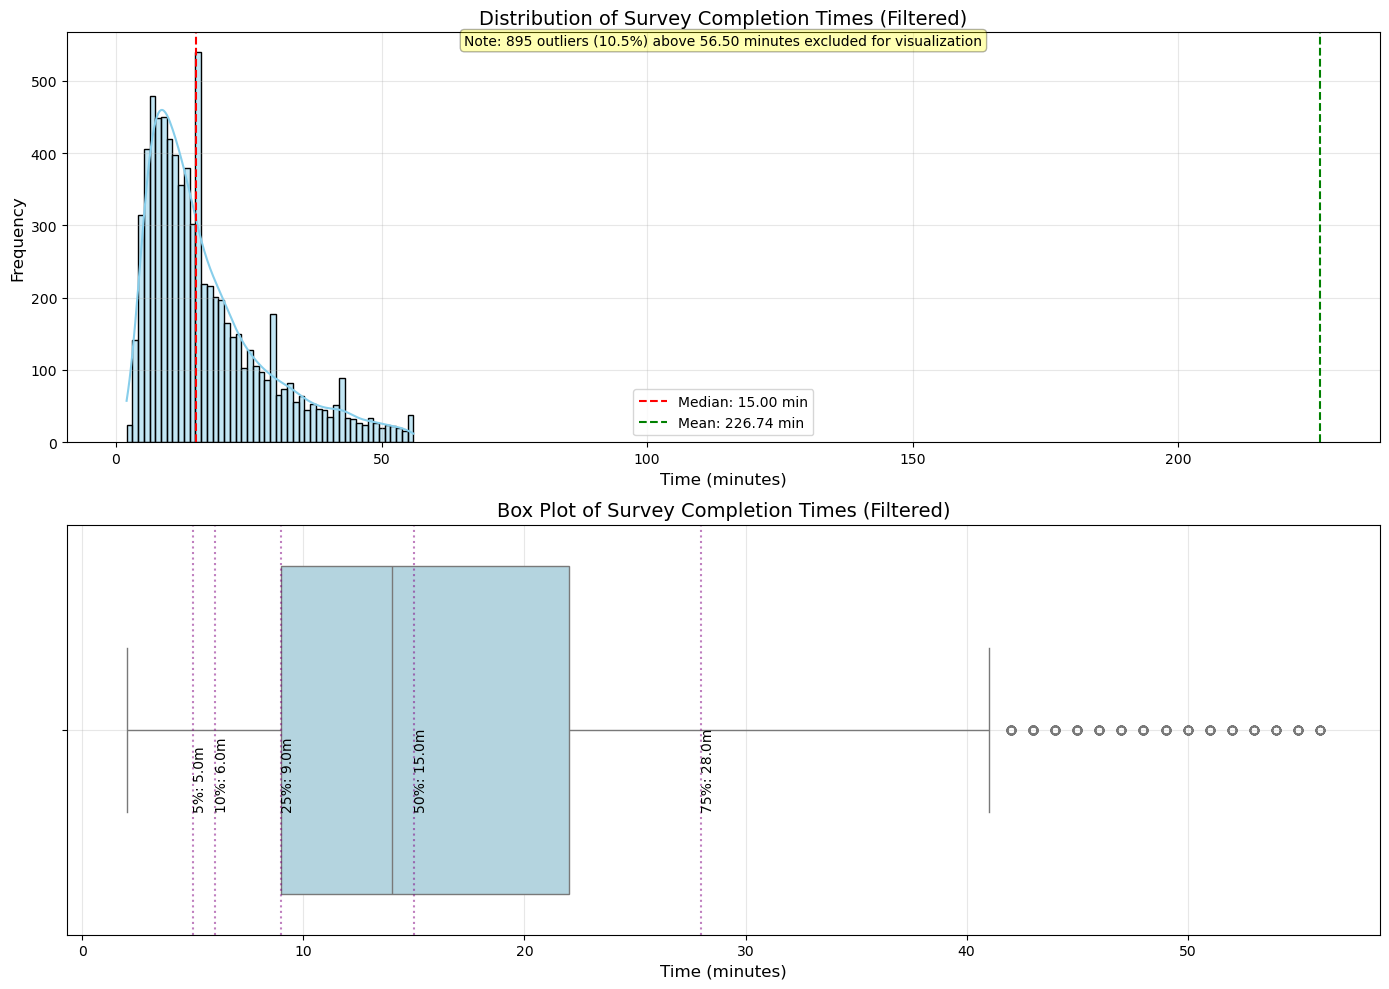


=== Response Time Distribution (in minutes) ===
Time Range           Count      Percentage
----------------------------------------
0-2 minutes          2          0.02      %
2-5 minutes          478        5.59      %
5-10 minutes         2,202      25.73     %
10-15 minutes        1,730      20.22     %
15-30 minutes        2,235      26.12     %
30-60 minutes        1,080      12.62     %
Over 60 minutes      831        9.71      %

=== Additional Insights ===
50% of respondents completed the survey in 15.00 minutes or less
90% of respondents completed the survey in 59.00 minutes or less
Skewness: 12.15 (Positive value indicates right-skewed distribution)
Kurtosis: 158.98 (Positive value indicates heavier tails than a normal distribution)


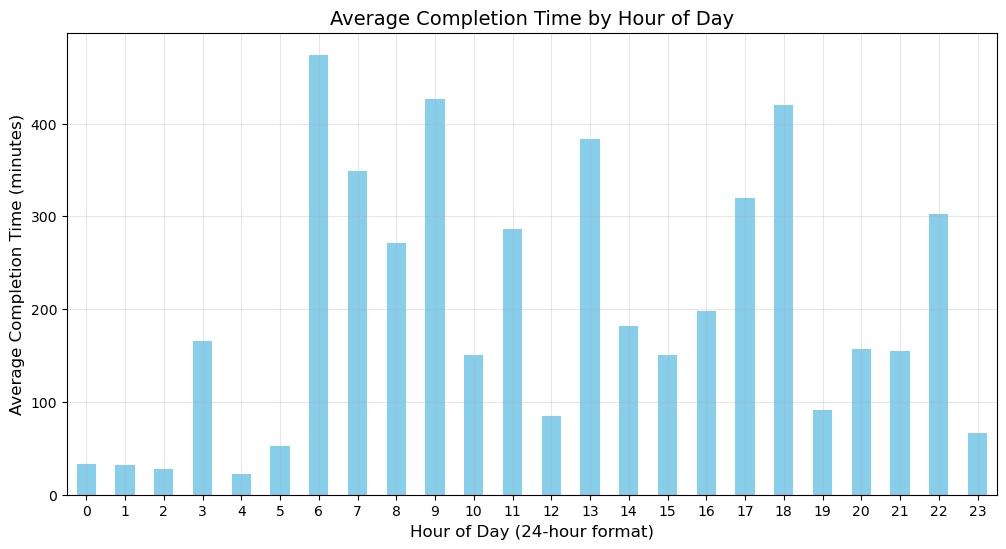


=== Time of Day Analysis ===
Fastest completion times: Hour 4 (Average: 21.98 minutes)
Slowest completion times: Hour 6 (Average: 474.13 minutes)

--- Response Time Distribution Analysis Complete ---


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- ASSUMPTION ---
# This code assumes the 'df_all_responses' DataFrame with 'Duration_sec' column 
# already exists in your environment from the previous steps.
# --- END ASSUMPTION ---

print("\n--- Response Time Distribution Analysis ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if 'Duration_sec' not in df_all_responses.columns:
        raise KeyError("'Duration_sec' column not found in df_all_responses. Please run the completion time analysis first.")
    
    # Create a copy of the duration data, dropping NaN values
    durations = df_all_responses['Duration_sec'].dropna().copy()
    
    # --- 1. Basic Statistics ---
    print("\n=== Basic Response Time Statistics (in seconds) ===")
    stats_to_report = {
        'Count': durations.count(),
        'Mean': durations.mean(),
        'Median': durations.median(),
        'Standard Deviation': durations.std(),
        'Minimum': durations.min(),
        'Maximum': durations.max(),
        'IQR (Interquartile Range)': durations.quantile(0.75) - durations.quantile(0.25),
        '5th Percentile': durations.quantile(0.05),
        '25th Percentile': durations.quantile(0.25),
        '75th Percentile': durations.quantile(0.75),
        '95th Percentile': durations.quantile(0.95)
    }
    
    # Format and display statistics
    for stat_name, stat_value in stats_to_report.items():
        print(f"{stat_name}: {stat_value:,.2f}")
    
    # --- 2. Convert to minutes for better interpretation ---
    durations_min = durations / 60
    
    # --- 3. Identify and handle outliers for visualization ---
    # Using IQR method to identify outliers
    Q1 = durations_min.quantile(0.25)
    Q3 = durations_min.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define upper bound for visualization (excluding extreme outliers)
    upper_bound = Q3 + 1.5 * IQR
    
    # Create a filtered dataset for better visualization
    durations_for_viz = durations_min[durations_min <= upper_bound]
    outliers_count = len(durations_min) - len(durations_for_viz)
    outliers_percent = (outliers_count / len(durations_min)) * 100
    
    # --- 4. Set up visualization environment ---
    plt.figure(figsize=(14, 10))
    
    # --- 5. Histogram with KDE (Kernel Density Estimate) ---
    plt.subplot(2, 1, 1)
    sns.histplot(durations_for_viz, kde=True, bins=50, color='skyblue')
    plt.axvline(durations_min.median(), color='red', linestyle='--', label=f'Median: {durations_min.median():.2f} min')
    plt.axvline(durations_min.mean(), color='green', linestyle='--', label=f'Mean: {durations_min.mean():.2f} min')
    plt.title('Distribution of Survey Completion Times (Filtered)', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add annotation about filtered outliers
    if outliers_count > 0:
        plt.annotate(f'Note: {outliers_count:,} outliers ({outliers_percent:.1f}%) above {upper_bound:.2f} minutes excluded for visualization',
                     xy=(0.5, 0.97), xycoords='axes fraction', ha='center', fontsize=10, 
                     bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
    
    # --- 6. Box Plot ---
    plt.subplot(2, 1, 2)
    sns.boxplot(x=durations_for_viz, color='lightblue')
    plt.title('Box Plot of Survey Completion Times (Filtered)', fontsize=14)
    plt.xlabel('Time (minutes)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add more detailed percentile markers
    percentiles = [5, 10, 25, 50, 75, 90, 95]
    percentile_values = [durations_min.quantile(p/100) for p in percentiles]
    
    for p, v in zip(percentiles, percentile_values):
        if v <= upper_bound:  # Only add if within the visualization range
            plt.axvline(v, color='purple', alpha=0.5, linestyle=':')
            plt.text(v, 0.2, f'{p}%: {v:.1f}m', rotation=90, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.savefig('response_time_distribution.png', dpi=300)
    plt.show()
    
    # --- 7. Calculate time ranges for reporting ---
    print("\n=== Response Time Distribution (in minutes) ===")
    
    # Define time ranges for categorization (in minutes)
    time_ranges = [
        (0, 2),        # 0-2 minutes
        (2, 5),        # 2-5 minutes
        (5, 10),       # 5-10 minutes
        (10, 15),      # 10-15 minutes
        (15, 30),      # 15-30 minutes
        (30, 60),      # 30-60 minutes
        (60, float('inf'))  # Over 60 minutes
    ]
    
    # Count responses in each time range
    range_counts = []
    for start, end in time_ranges:
        if start == 0:
            count = ((durations_min >= start) & (durations_min <= end)).sum()
            label = f"{start}-{end} minutes"
        elif end == float('inf'):
            count = (durations_min > start).sum()
            label = f"Over {start} minutes"
        else:
            count = ((durations_min > start) & (durations_min <= end)).sum()
            label = f"{start}-{end} minutes"
        
        percentage = (count / len(durations_min)) * 100
        range_counts.append((label, count, percentage))
    
    # Display time range distribution
    print(f"{'Time Range':<20} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)
    for label, count, percentage in range_counts:
        print(f"{label:<20} {count:<10,d} {percentage:<10.2f}%")
    
    # --- 8. Additional summary statistics ---
    print("\n=== Additional Insights ===")
    
    # Time to complete for 50% of respondents
    median_time = durations_min.median()
    print(f"50% of respondents completed the survey in {median_time:.2f} minutes or less")
    
    # Time to complete for 90% of respondents
    p90_time = durations_min.quantile(0.90)
    print(f"90% of respondents completed the survey in {p90_time:.2f} minutes or less")
    
    # Skewness and kurtosis
    skewness = stats.skew(durations_min)
    kurtosis = stats.kurtosis(durations_min)
    print(f"Skewness: {skewness:.2f} (Positive value indicates right-skewed distribution)")
    print(f"Kurtosis: {kurtosis:.2f} (Positive value indicates heavier tails than a normal distribution)")
    
    # --- 9. Create a time-of-day analysis ---
    # Extract hour from the start time
    if 'Started_dt' in df_all_responses.columns:
        df_all_responses['Hour_Started'] = df_all_responses['Started_dt'].dt.hour
        
        # Group by hour and calculate average completion time
        hourly_avg = df_all_responses.groupby('Hour_Started')['Duration_sec'].mean() / 60  # Convert to minutes
        
        # Create hour of day vs. completion time plot
        plt.figure(figsize=(12, 6))
        hourly_avg.plot(kind='bar', color='skyblue')
        plt.title('Average Completion Time by Hour of Day', fontsize=14)
        plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
        plt.ylabel('Average Completion Time (minutes)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=0)
        plt.savefig('completion_time_by_hour.png', dpi=300)
        plt.show()
        
        # Report findings
        print("\n=== Time of Day Analysis ===")
        fastest_hour = hourly_avg.idxmin()
        slowest_hour = hourly_avg.idxmax()
        print(f"Fastest completion times: Hour {fastest_hour} (Average: {hourly_avg[fastest_hour]:.2f} minutes)")
        print(f"Slowest completion times: Hour {slowest_hour} (Average: {hourly_avg[slowest_hour]:.2f} minutes)")
    
except NameError as e:
    print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Response Time Distribution Analysis Complete ---")

# 2.  Straightlining
*We try to find areas of responses where they are clicking the same option, potentially indicates action without thought*

**Definition**
We define this based on 'question blocks', pattern matching column names.  These are:

PA Frequency Questions: All questions beginning with "How often do physician associates..."

PA Appropriateness Questions: All questions beginning with "Do you believe it is appropriate for physician..."

AA Frequency Questions: All questions beginning with "How often do anaesthesia associates..."

AA Appropriateness Questions: All questions beginning with "Do you believe it is appropriate for anaesthesi..."

Agreement Questions: All questions beginning with "Do you agree or disagree..."

Confidence Questions: All questions beginning with "How confident..."

Our analysis suggests 70.5% of the respondents didn't straight-line any blocks. They varied their answers within each question block.
23.6% straight-lined exactly one block. They gave identical answers for all questions in one of the blocks but varied their answers in the other block.
5.3% straight-lined 2 blocks, 0.7% straight-lined 4 blocks.
0.0% straight-lined all four blocks.

We may flag those with 2+ blocks straight-lined (6%) but this is not large enough to fundamentally alter the results. It is not inconsistent with individuals holding strong, consistent views on questions on similar topics.


--- Running Straight-Lining Detection ---

Identified Question Blocks for Straight-Lining Detection:
PA Frequency Questions: 17 questions
PA Appropriateness Questions: 17 questions
AA Frequency Questions: 12 questions
AA Appropriateness Questions: 12 questions
Agreement Questions: 4 questions
Confidence Questions: 4 questions

=== Straight-Lining Detection Results ===

Detailed Straight-Lining Analysis by Question Block (Total Responses: 8,558):
Question Block                      Questions  Count      Percentage
-----------------------------------------------------------------
PA Appropriateness Questions        17         1,158      13.53     %
Confidence Questions                4          584        6.82      %
AA Appropriateness Questions        12         496        5.80      %
Agreement Questions                 4          469        5.48      %
PA Frequency Questions              17         288        3.37      %
AA Frequency Questions              12         100        1.17  

C:\Users\lslater2\AppData\Local\Temp\1\ipykernel_11836\1482979141.py:190: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Count_Straightlining_Blocks', data=df_all_responses,



=== Combined Suspicious Response Detection ===
Responses flagged as suspicious (short time OR multiple straight-lining): 633 (7.40%)
- Short completion time only: 125 (1.46%)
- Multiple straight-lining only: 468 (5.47%)
- Both issues: 40 (0.47%)

=== Sample of Suspicious Responses ===
      Duration_sec                           Response ID     Status             Created           Completed  Flag_ShortTime  Flag_Straightlining_PAFrequencyQuestions  Flag_Straightlining_PAAppropriatenessQuestions  Flag_Straightlining_AAFrequencyQuestions  Flag_Straightlining_AAAppropriatenessQuestions  Flag_Straightlining_AgreementQuestions  Flag_Straightlining_ConfidenceQuestions  Flag_MultipleStrightlining  Flag_SuspiciousResponse  Total_Flags
8485         240.0  936a6b14-4224-4e29-b8a5-7f000342b593  completed 2025-03-07 20:59:00 2025-03-07 21:03:00            True                                      True                                            True                                     False       

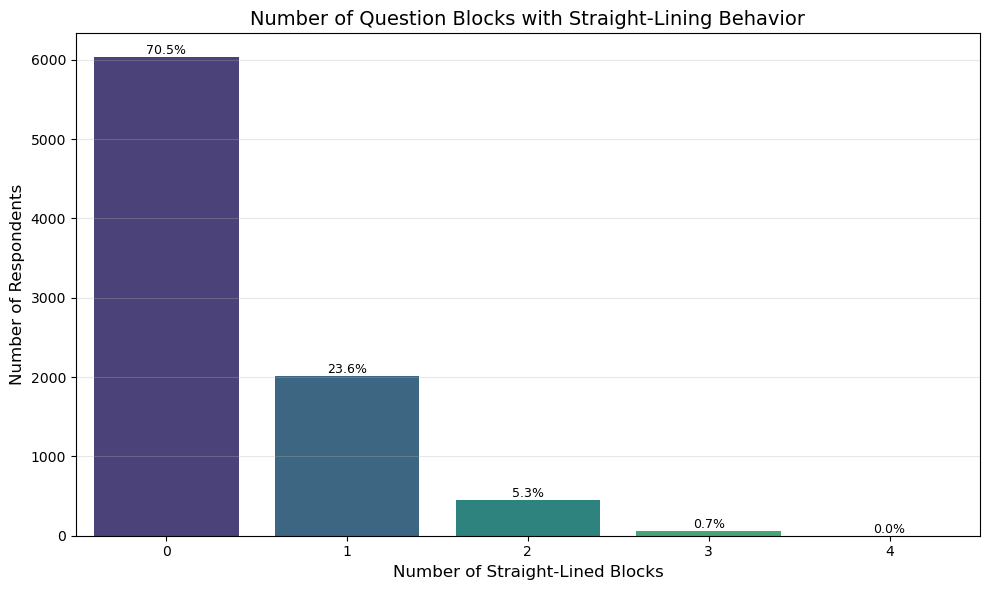

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- ASSUMPTION ---
# This code assumes the following variables are already in your environment:
# 1. 'df_all_responses' DataFrame with all survey responses
# 2. 'column_metadata_df' DataFrame with column classification (from previous code cells)
# --- END ASSUMPTION ---

print("\n--- Running Straight-Lining Detection ---")

try:
    # --- Basic Checks ---
    if 'df_all_responses' not in locals():
        raise NameError("The DataFrame 'df_all_responses' does not exist. Please load it first.")
    if 'column_metadata_df' not in locals():
        raise NameError("The 'column_metadata_df' DataFrame is not available. Please run the column analysis first.")
    
    # --- 1. Define Question Blocks ---
    # We'll identify blocks of related questions for straight-lining detection
    
    # Block 1: Physician Associate frequency questions
    pa_frequency_columns = [col for col in df_all_responses.columns if 
                         col.startswith('How often do physician associates') and
                         'ResponseType' in column_metadata_df.columns and
                         col in column_metadata_df.index and
                         column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 2: Physician Associate appropriateness questions
    pa_appropriate_columns = [col for col in df_all_responses.columns if 
                            col.startswith('Do you believe it is appropriate for physician') and
                            'ResponseType' in column_metadata_df.columns and
                            col in column_metadata_df.index and
                            column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 3: Anaesthesia Associate frequency questions
    aa_frequency_columns = [col for col in df_all_responses.columns if 
                          col.startswith('How often do anaesthesia associates') and
                          'ResponseType' in column_metadata_df.columns and
                          col in column_metadata_df.index and
                          column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 4: Anaesthesia Associate appropriateness questions
    aa_appropriate_columns = [col for col in df_all_responses.columns if 
                            col.startswith('Do you believe it is appropriate for anaesthesi') and
                            'ResponseType' in column_metadata_df.columns and
                            col in column_metadata_df.index and
                            column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 5: Agreement questions about roles
    agreement_columns = [col for col in df_all_responses.columns if 
                        col.startswith('Do you agree or disagree') and
                        'ResponseType' in column_metadata_df.columns and
                        col in column_metadata_df.index and
                        column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Block 6: Confidence questions
    confidence_columns = [col for col in df_all_responses.columns if 
                         col.startswith('How confident') and
                         'ResponseType' in column_metadata_df.columns and
                         col in column_metadata_df.index and
                         column_metadata_df.loc[col, 'ResponseType'] == 'Fixed Response']
    
    # Combine all identified blocks for reporting
    all_blocks = {
        "PA Frequency Questions": pa_frequency_columns,
        "PA Appropriateness Questions": pa_appropriate_columns,
        "AA Frequency Questions": aa_frequency_columns,
        "AA Appropriateness Questions": aa_appropriate_columns,
        "Agreement Questions": agreement_columns,
        "Confidence Questions": confidence_columns
    }
    
    # Print block sizes for verification
    print("\nIdentified Question Blocks for Straight-Lining Detection:")
    for block_name, columns in all_blocks.items():
        print(f"{block_name}: {len(columns)} questions")
    
    # --- 2. Define Functions for Straight-Lining Detection ---
    
    def detect_straightlining(df, column_group, min_questions=3, threshold=1):
        """
        Detect straight-lining behavior in a group of related questions.
        
        Parameters:
        - df: DataFrame containing survey responses
        - column_group: List of column names to check for straight-lining
        - min_questions: Minimum number of questions that must be answered
        - threshold: Maximum number of unique responses allowed to be flagged
        
        Returns:
        - Series with True for rows exhibiting straight-lining, False otherwise
        """
        if len(column_group) < min_questions:
            # Not enough questions to reliably detect straight-lining
            return pd.Series(False, index=df.index)
        
        # Count non-NaN values in each row for these columns
        answered_count = df[column_group].notna().sum(axis=1)
        
        # Count unique non-NaN values in each row for these columns
        def count_unique_nonnan(row):
            values = row[column_group].dropna().unique()
            return len(values)
        
        unique_values_count = df.apply(count_unique_nonnan, axis=1)
        
        # Flag as straight-lining if:
        # 1. At least min_questions have been answered, AND
        # 2. The number of unique answers is <= threshold
        straightlining_flag = (answered_count >= min_questions) & (unique_values_count <= threshold)
        
        return straightlining_flag
    
    # --- 3. Apply Straight-Lining Detection to Each Block ---
    
    # Initialize a dictionary to store the flags for each block
    straightlining_flags = {}
    
    # Process each block
    for block_name, columns in all_blocks.items():
        if columns:  # Only process non-empty blocks
            flag_column_name = f"Flag_Straightlining_{block_name.replace(' ', '')}"
            straightlining_flags[block_name] = detect_straightlining(
                df_all_responses, 
                columns, 
                min_questions=min(3, len(columns)),  # At least 3 questions or all if fewer
                threshold=1  # Flag if only 1 unique answer
            )
            
            # Add the flag to the main DataFrame
            df_all_responses[flag_column_name] = straightlining_flags[block_name]
    
    # --- 4. Analyze Overall Straight-Lining Behavior ---
    
    # Count how many blocks each respondent straight-lined
    flag_columns = [f"Flag_Straightlining_{block_name.replace(' ', '')}" for block_name in all_blocks.keys() 
                   if all_blocks[block_name]]  # Only include blocks with questions
    
    if flag_columns:
        df_all_responses['Count_Straightlining_Blocks'] = df_all_responses[flag_columns].sum(axis=1)
        
        # Create an overall flag for responses with multiple straight-lined blocks
        df_all_responses['Flag_MultipleStrightlining'] = df_all_responses['Count_Straightlining_Blocks'] >= 2
    
    # --- 5. Generate Summary Statistics ---
    
    print("\n=== Straight-Lining Detection Results ===")
    
    # Report on each block
    total_responses = len(df_all_responses)
    block_results = []
    
    for block_name, columns in all_blocks.items():
        if columns:  # Only report on non-empty blocks
            flag_column = f"Flag_Straightlining_{block_name.replace(' ', '')}"
            straight_lined_count = df_all_responses[flag_column].sum()
            percentage = (straight_lined_count / total_responses) * 100
            block_results.append((block_name, len(columns), straight_lined_count, percentage))
    
    # Sort blocks by percentage of straight-lining (descending)
    block_results.sort(key=lambda x: x[3], reverse=True)
    
    # Print block-specific results
    print(f"\nDetailed Straight-Lining Analysis by Question Block (Total Responses: {total_responses:,}):")
    print(f"{'Question Block':<35} {'Questions':<10} {'Count':<10} {'Percentage':<10}")
    print("-" * 65)
    for block_name, num_questions, count, percentage in block_results:
        print(f"{block_name:<35} {num_questions:<10d} {count:<10,d} {percentage:<10.2f}%")
    
    # Report on multiple straight-lining
    if 'Count_Straightlining_Blocks' in df_all_responses.columns:
        multi_sl_count = df_all_responses['Flag_MultipleStrightlining'].sum()
        multi_sl_percentage = (multi_sl_count / total_responses) * 100
        
        print(f"\nRespondents who straight-lined multiple question blocks: {multi_sl_count:,} ({multi_sl_percentage:.2f}%)")
        
        # Distribution of straight-lined blocks
        sl_block_counts = df_all_responses['Count_Straightlining_Blocks'].value_counts().sort_index()
        print("\nDistribution of straight-lined question blocks:")
        for blocks_count, responses_count in sl_block_counts.items():
            percentage = (responses_count / total_responses) * 100
            print(f"{blocks_count} blocks: {responses_count:,} responses ({percentage:.2f}%)")
    
    # --- 6. Visualize the Straight-Lining Distribution ---
    if 'Count_Straightlining_Blocks' in df_all_responses.columns:
        plt.figure(figsize=(10, 6))
        ax = sns.countplot(x='Count_Straightlining_Blocks', data=df_all_responses, 
                          palette='viridis', order=sorted(df_all_responses['Count_Straightlining_Blocks'].unique()))
        
        # Add percentage labels on top of bars
        total = len(df_all_responses)
        for p in ax.patches:
            height = p.get_height()
            percentage = 100 * height / total
            ax.annotate(f'{percentage:.1f}%', 
                       (p.get_x() + p.get_width() / 2., height), 
                       ha='center', va='bottom', fontsize=9)
        
        plt.title('Number of Question Blocks with Straight-Lining Behavior', fontsize=14)
        plt.xlabel('Number of Straight-Lined Blocks', fontsize=12)
        plt.ylabel('Number of Respondents', fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.savefig('straightlining_distribution.png', dpi=300)
        # plt.show()  # Uncomment to display the plot in interactive environments
    
    # --- 7. Create a Combined Suspicious Response Flag ---
    
    # Combine straight-lining with short completion time
    if 'Flag_ShortTime' in df_all_responses.columns and 'Flag_MultipleStrightlining' in df_all_responses.columns:
        df_all_responses['Flag_SuspiciousResponse'] = df_all_responses['Flag_ShortTime'] | df_all_responses['Flag_MultipleStrightlining']
        
        suspicious_count = df_all_responses['Flag_SuspiciousResponse'].sum()
        suspicious_percentage = (suspicious_count / total_responses) * 100
        
        print(f"\n=== Combined Suspicious Response Detection ===")
        print(f"Responses flagged as suspicious (short time OR multiple straight-lining): {suspicious_count:,} ({suspicious_percentage:.2f}%)")
        
        # Show breakdown of suspicious responses
        short_time_only = (df_all_responses['Flag_ShortTime'] & ~df_all_responses['Flag_MultipleStrightlining']).sum()
        straight_line_only = (~df_all_responses['Flag_ShortTime'] & df_all_responses['Flag_MultipleStrightlining']).sum()
        both_issues = (df_all_responses['Flag_ShortTime'] & df_all_responses['Flag_MultipleStrightlining']).sum()
        
        print(f"- Short completion time only: {short_time_only:,} ({short_time_only/total_responses*100:.2f}%)")
        print(f"- Multiple straight-lining only: {straight_line_only:,} ({straight_line_only/total_responses*100:.2f}%)")
        print(f"- Both issues: {both_issues:,} ({both_issues/total_responses*100:.2f}%)")
    
    # --- 8. Sample of Suspicious Responses ---
    if 'Flag_SuspiciousResponse' in df_all_responses.columns and df_all_responses['Flag_SuspiciousResponse'].sum() > 0:
        # Get all flag columns for context
        flag_cols = [col for col in df_all_responses.columns if col.startswith('Flag_')]
        
        # Add some metadata columns if they exist
        context_cols = ['Duration_sec']
        context_cols.extend([col for col in ['Response ID', 'Status', 'Created', 'Completed'] 
                           if col in df_all_responses.columns])
        
        display_cols = context_cols + flag_cols
        
        print("\n=== Sample of Suspicious Responses ===")
        
        # Show a sample of suspicious responses, sorted by number of flags
        suspicious_sample = df_all_responses[df_all_responses['Flag_SuspiciousResponse']][display_cols].copy()
        
        # Count how many flags each response has
        flag_count = suspicious_sample[flag_cols].sum(axis=1)
        suspicious_sample['Total_Flags'] = flag_count
        
        # Sort by total flags (descending) and duration (ascending)
        sorted_sample = suspicious_sample.sort_values(['Total_Flags', 'Duration_sec'], ascending=[False, True])
        
        # Display the top rows
        with pd.option_context('display.max_rows', 10, 'display.max_columns', None, 'display.width', 1000):
            print(sorted_sample.head(10))
            
        # Optionally save suspicious responses to a CSV file
        # sorted_sample.to_csv('suspicious_responses.csv', index=True)
        # print("Saved all suspicious responses to 'suspicious_responses.csv'")

except NameError as e:
    print(f"Error: {e}")
except KeyError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("\n--- Straight-Lining Detection Complete ---")
print("The DataFrame 'df_all_responses' now has new flag columns for straight-lining detection.")